In [1]:
#Importing required Packages
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

import helper
import zipfile
from PIL import Image

import time
import seaborn as sns
from tqdm import tqdm
import os

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

noise_color = 'w'

In [2]:
train_transforms = transforms.Compose([#transforms.RandomResizedCrop(256),
                                       transforms.RandomRotation(30),
                                       transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([#transforms.RandomResizedCrop(256),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([#transforms.RandomResizedCrop(256),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
clean_set = DatasetFolder('flower102_preprocess_set_' + noise_color, loader=lambda x: Image.open(x), extensions="jpg", transform = train_transforms)
adv_set = DatasetFolder('flower_adv_set_' + noise_color, loader=lambda x: Image.open(x), extensions="jpg", transform = train_transforms)

train_set = ConcatDataset([clean_set, adv_set])
train_set, valid_set = random_split(train_set, [int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=0)
#test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0)

Debugger :  class -> idx 
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97, '98': 98, '99

In [4]:
model = models.densenet201(weights='DenseNet201_Weights.DEFAULT')

#Freeze denseblock layers for retraining, Optional
for name, child in model.features.named_children():
    if name in ['conv0', 'norm0','relu0','pool0','denseblock1','transition1','denseblock2','transition2','transition3','norm5']:
        #print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

    else:
        #print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True

            
# * Define a new, untrained feed-forward network as a classifier
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierH2(nn.Module):
    def __init__(self, inp = 1920, h1=1024, output = 102, drop=0.35):
        super().__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d((1,1))
        self.maxPool = nn.AdaptiveMaxPool2d((1,1))
        
        self.fla = Flatten()
        self.batchN0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(drop)
        self.fc1 = nn.Linear(inp*2, h1)
        self.batchN1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(drop)

        self.fc3 = nn.Linear(h1, output)
        
    def forward(self, x):
        adaptivePool = self.adaptivePool(x)
        maxPool = self.maxPool(x)
        x = torch.cat((adaptivePool,maxPool),dim=1)
        x = self.fla(x)
        x = self.batchN0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.batchN1(x)
        x = self.dropout1(x)         
        x = self.fc3(x)
        
        return x

In [5]:
#Set Model
path = f'output_model_{noise_color}'

if not os.path.isdir(path):
    os.mkdir(path)

model = nn.Sequential(*list(model.children())[:-1],ClassifierH2())
     
model = model.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
sched = lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)

n_epochs = 50
best_acc = 0

train_loss, valid_loss = [], []
for epoch in range(n_epochs):
    print(f'Epoch : {epoch} | Training')
    model.train()
    t_loss = 0
    train_total = 0
    for batch in tqdm(train_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device, dtype = torch.float), labels.to(device)
        
        train_total += imgs.shape[0]
        
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        sched.step()
        t_loss += loss.item()
    
    v_loss = 0
    accuracy = 0
    model.eval()
    eval_total = 0
    print(f'Epoch : {epoch} | Evaluating')
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
            eval_total += imgs.shape[0]
            
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            #print(preds)
            #print(labels)
            
            loss = criterion(outputs, labels)
            
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            #equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.sum(preds == labels.data)
    train_loss.append(t_loss/train_total)
    valid_loss.append(v_loss/eval_total)
    
    print(f'Epoch: Accuracy = {accuracy/eval_total} | Train loss = {t_loss/train_total} | validation loss = {v_loss/eval_total}')
    
    v_loss = v_loss/eval_total
    
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), f'./output_model_{noise_color}/flower102_20230520{epoch}_{noise_color}.pt')
        print('model save !')

Epoch : 0 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 0 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch: Accuracy = 0.6831750273704529 | Train loss = 0.014408504067233978 | validation loss = 0.01135156326895653
model save !
Epoch : 1 | Training


100%|██████████| 93/93 [00:45<00:00,  2.04it/s]


Epoch : 1 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch: Accuracy = 0.7160786986351013 | Train loss = 0.010110784685959487 | validation loss = 0.009860826431289618
model save !
Epoch : 2 | Training


100%|██████████| 93/93 [00:45<00:00,  2.02it/s]


Epoch : 2 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch: Accuracy = 0.7360922694206238 | Train loss = 0.009198663541427947 | validation loss = 0.009149013079571432
model save !
Epoch : 3 | Training


100%|██████████| 93/93 [00:45<00:00,  2.02it/s]


Epoch : 3 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.7591587901115417 | Train loss = 0.008582287931781934 | validation loss = 0.00836183711017003
model save !
Epoch : 4 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 4 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.7683175206184387 | Train loss = 0.007847185596682162 | validation loss = 0.008947939630926383
model save !
Epoch : 5 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 5 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.7913839817047119 | Train loss = 0.007253174805252976 | validation loss = 0.007864046836805149
model save !
Epoch : 6 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 6 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.7893487215042114 | Train loss = 0.006788104762458413 | validation loss = 0.007222473631477744
Epoch : 7 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 7 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.7961329817771912 | Train loss = 0.0063352912229712 | validation loss = 0.00699347674118777
model save !
Epoch : 8 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 8 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.8093622922897339 | Train loss = 0.005908427813079011 | validation loss = 0.00653437776756416
model save !
Epoch : 9 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 9 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.8205563426017761 | Train loss = 0.00550510195744814 | validation loss = 0.0062548807206762045
model save !
Epoch : 10 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 10 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8266621828079224 | Train loss = 0.005110319486466644 | validation loss = 0.005967987238794686
model save !
Epoch : 11 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 11 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch: Accuracy = 0.8290366530418396 | Train loss = 0.004781596279188768 | validation loss = 0.006478935540773814
model save !
Epoch : 12 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 12 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.8398914933204651 | Train loss = 0.004500070786459961 | validation loss = 0.005341880857499677
model save !
Epoch : 13 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 13 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.8422659635543823 | Train loss = 0.004223251043031627 | validation loss = 0.005886270605239972
model save !
Epoch : 14 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 14 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.8527815341949463 | Train loss = 0.003974254888809681 | validation loss = 0.005418683428777283
model save !
Epoch : 15 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 15 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.8551560640335083 | Train loss = 0.0036807604503073556 | validation loss = 0.004931983410341607
model save !
Epoch : 16 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 16 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.8551560640335083 | Train loss = 0.0035387825731344755 | validation loss = 0.004752497182428594
Epoch : 17 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 17 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.8565129041671753 | Train loss = 0.003219571828923038 | validation loss = 0.005235754105096918
model save !
Epoch : 18 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 18 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.8629579544067383 | Train loss = 0.0031146437758668307 | validation loss = 0.004475737177593737
model save !
Epoch : 19 | Training


100%|██████████| 93/93 [00:45<00:00,  2.02it/s]


Epoch : 19 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch: Accuracy = 0.863297164440155 | Train loss = 0.0029181935868682176 | validation loss = 0.004660141981602362
model save !
Epoch : 20 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 20 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8680461645126343 | Train loss = 0.0027282170236130904 | validation loss = 0.004264769021780552
model save !
Epoch : 21 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 21 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.8714382648468018 | Train loss = 0.0025815522181959457 | validation loss = 0.0042623201716221176
model save !
Epoch : 22 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 22 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.8758480548858643 | Train loss = 0.0024172269310827493 | validation loss = 0.004142063312242604
model save !
Epoch : 23 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 23 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8751696348190308 | Train loss = 0.0022705183787779374 | validation loss = 0.004058661422056615
Epoch : 24 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 24 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8850067853927612 | Train loss = 0.002164477769290495 | validation loss = 0.00410744615576484
model save !
Epoch : 25 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 25 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch: Accuracy = 0.8856852054595947 | Train loss = 0.002003806391718268 | validation loss = 0.0038159111643581572
model save !
Epoch : 26 | Training


100%|██████████| 93/93 [00:45<00:00,  2.02it/s]


Epoch : 26 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch: Accuracy = 0.8860244154930115 | Train loss = 0.0018952590030500492 | validation loss = 0.0038593631829141437
model save !
Epoch : 27 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 27 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8850067853927612 | Train loss = 0.0017978341155653892 | validation loss = 0.0036513217291421936
Epoch : 28 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 28 | Evaluating


100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch: Accuracy = 0.890434205532074 | Train loss = 0.0016865899541201714 | validation loss = 0.003977298908430977
model save !
Epoch : 29 | Training


100%|██████████| 93/93 [00:46<00:00,  2.02it/s]


Epoch : 29 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8951832056045532 | Train loss = 0.001601714864524847 | validation loss = 0.003488918053671172
model save !
Epoch : 30 | Training


100%|██████████| 93/93 [00:47<00:00,  1.96it/s]


Epoch : 30 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch: Accuracy = 0.8924694657325745 | Train loss = 0.0014755150310826592 | validation loss = 0.004067008215504392
Epoch : 31 | Training


100%|██████████| 93/93 [00:47<00:00,  1.94it/s]


Epoch : 31 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch: Accuracy = 0.8887381553649902 | Train loss = 0.001395321672269253 | validation loss = 0.0034778640306020203
Epoch : 32 | Training


100%|██████████| 93/93 [00:46<00:00,  1.98it/s]


Epoch : 32 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch: Accuracy = 0.8951832056045532 | Train loss = 0.0013289967225801347 | validation loss = 0.003407771265692756
Epoch : 33 | Training


100%|██████████| 93/93 [00:46<00:00,  1.98it/s]


Epoch : 33 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch: Accuracy = 0.894165575504303 | Train loss = 0.0012266581083219524 | validation loss = 0.003372929398895442
Epoch : 34 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 34 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch: Accuracy = 0.8985753059387207 | Train loss = 0.0011793027999665554 | validation loss = 0.0033668979011688338
model save !
Epoch : 35 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 35 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch: Accuracy = 0.896879255771637 | Train loss = 0.0010526797505477229 | validation loss = 0.0032425731511500993
Epoch : 36 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 36 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch: Accuracy = 0.899592936038971 | Train loss = 0.001042910284151701 | validation loss = 0.003215128536938893
model save !
Epoch : 37 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 37 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch: Accuracy = 0.9016282558441162 | Train loss = 0.0010079704762121797 | validation loss = 0.0032330217848315817
model save !
Epoch : 38 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 38 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch: Accuracy = 0.8951832056045532 | Train loss = 0.0009124078639382383 | validation loss = 0.0032311415595471294
Epoch : 39 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 39 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch: Accuracy = 0.9016282558441162 | Train loss = 0.0008765235382133496 | validation loss = 0.0033854807258218407
Epoch : 40 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 40 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.9036635160446167 | Train loss = 0.0008115193934850849 | validation loss = 0.003083846020023244
model save !
Epoch : 41 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 41 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch: Accuracy = 0.9043419361114502 | Train loss = 0.0007536463000972122 | validation loss = 0.0030624725965825964
model save !
Epoch : 42 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 42 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch: Accuracy = 0.9026458859443665 | Train loss = 0.0007228482084341215 | validation loss = 0.0031484588829034706
Epoch : 43 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 43 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch: Accuracy = 0.9060379862785339 | Train loss = 0.0006661170928042731 | validation loss = 0.0036968185011615907
model save !
Epoch : 44 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 44 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch: Accuracy = 0.9073948860168457 | Train loss = 0.0006340774900205383 | validation loss = 0.003086355892660822
model save !
Epoch : 45 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 45 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch: Accuracy = 0.9121438264846802 | Train loss = 0.0006050540512147154 | validation loss = 0.003142290110503964
model save !
Epoch : 46 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 46 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Epoch: Accuracy = 0.9043419361114502 | Train loss = 0.0005820193182641648 | validation loss = 0.0029553288677290302
Epoch : 47 | Training


100%|██████████| 93/93 [00:47<00:00,  1.98it/s]


Epoch : 47 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch: Accuracy = 0.9107869863510132 | Train loss = 0.0005578826045114522 | validation loss = 0.003309365174906225
Epoch : 48 | Training


100%|██████████| 93/93 [00:46<00:00,  2.00it/s]


Epoch : 48 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch: Accuracy = 0.9097693562507629 | Train loss = 0.0005288868422242162 | validation loss = 0.0028357590742035185
Epoch : 49 | Training


100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch : 49 | Evaluating


100%|██████████| 24/24 [00:07<00:00,  3.35it/s]

Epoch: Accuracy = 0.9070556163787842 | Train loss = 0.0005116477640904234 | validation loss = 0.00327353440275671


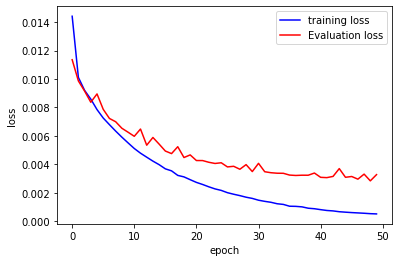

In [6]:
epochs = np.arange(n_epochs)
plt.figure(0)
plt.plot(epochs, train_loss, color = 'b', label = 'training loss')
plt.plot(epochs, valid_loss, color = 'r', label = 'Evaluation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.savefig(f'./output_model_{noise_color}/loss_surface.png')
#plt.clf()